In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
batting = pd.read_csv("baseballdatabank-master/core/batting.csv")
pitching = pd.read_csv("baseballdatabank-master/core/pitching.csv")
schedule2019init = pd.read_excel("baseballdatabank-master/core/2019.xlsx")
pd.set_option('display.max_columns', None)

In [3]:
#Our initial step of the project is to create a strength of schedule statistic that is based off
#the batting average allowed by the pitchers on every team as another consideration for predicting batting average.
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [4]:
#We want to get rid of 2020 because it was not a full season and we are going to be completely ignoring it for the sake out our project
no2020 = pitching[pitching['yearID'] != 2020]

In [5]:
#These are the only vital columns we need from the pitching table
lesscols = no2020[['playerID','yearID','stint','teamID','BAOpp','BFP']]

In [6]:
#Here we are taking all rows from 2019 in order to figure out all people who pitched during the year
pitching2019 = lesscols[lesscols["yearID"] == 2019]

In [7]:
#After we only have 2019 data we just need ID's of all players who pitched in 2019
pitch_id = pitching2019['playerID']

In [8]:
#Using the ID's of all players who pitched in 2019 we can extract the career data of every pitcher that pitched in 2019
all2019pitchers = lesscols[lesscols['playerID'].isin(pitch_id)]

In [9]:
all2019pitchers

,playerID,yearID,stint,teamID,BAOpp,BFP
34083,sabatcc01,2001,1,CLE,0.228,763.0
34667,perezol01,2002,1,SDN,0.218,387.0
34728,rodnefe01,2002,1,DET,0.329,89.0
34744,sabatcc01,2002,1,CLE,0.252,891.0
35165,jacksed01,2003,1,LAN,0.221,91.0
...,...,...,...,...,...,...
47624,zamorda01,2019,1,NYN,0.294,41.0
47625,zeuchtj01,2019,1,TOR,0.250,99.0
47626,zimmejo02,2019,1,DET,0.311,504.0
47627,zimmeky01,2019,1,KCA,0.337,102.0


In [10]:
#Our data goes up to the year 2019 but in our hypothetical scenario the 2019 season has not happened yet so we will remove the year 2019
existingpitchers = all2019pitchers[all2019pitchers['yearID'] != 2019]

In [11]:
#In order to figure out everyones BAOpp per year we need to average every stint each person had each year so we have overall year performance
stintavg = existingpitchers.groupby(['playerID','yearID']).agg({'BAOpp':'mean','BFP':'sum'})
stintavg.head(n=10)

BAOpp    BFP
playerID  yearID               
abadfe01  2010    0.2000   76.0
          2011    0.3260   99.0
          2012    0.3110  208.0
          2013    0.2710  166.0
          2014    0.1750  216.0
          2015    0.2510  205.0
          2016    0.2375  198.0
          2017    0.2420  182.0
adamja01  2018    0.2460  142.0
adamsau01 2014    0.3100   30.0

In [12]:
#This is for making a column full of 1's to represent each year for use in aggregating years played later
ones = [1] * len(stintavg.index)
stintavg['years'] = ones

In [13]:
#Now that we have an accurate BAOpp for every year we want we want to average every year together to get their career BAOpp

#Additionally when we collect all the years into a career stat we are also finally suming the years column so we know how many years they played
#and we are summing BFP so we know how many hitters a pitcher faced their entire career
careeravg = stintavg.groupby(['playerID']).agg({'BAOpp':'mean','BFP':'sum', 'years':'sum'})

In [14]:
careeravg

,BAOpp,BFP,years
playerID,,,
abadfe01,0.251688,1350.0,8
adamja01,0.246000,142.0,1
adamsau01,0.306333,267.0,3
adamsau02,0.230500,36.0,2
adamsch01,0.267000,34.0,1
...,...,...,...
yarbrry01,0.246000,628.0,1
yateski01,0.251400,913.0,5
ynoaga01,0.311000,235.0,2


In [15]:
#In order to create a weighted average on BAOpp that emphasises players 2018 BAOpp we need to extract just their 2018 BAOpp
pitching2018 = existingpitchers[existingpitchers['yearID'] == 2018]

In [16]:
#This part is necessary in order to average every players stints in 2018 in order to get a total year performance
pitching2018avg = pitching2018.groupby(['playerID']).agg({'BAOpp':'mean'})

In [17]:
#Here we want to join each of the last two tables we made on each player so we can have each players career and 2018 BAOpp and side by side
pitchingBAOpp = careeravg.merge(pitching2018avg, on='playerID', how='left', suffixes=['_career', '_2018'])

In [18]:
#We noticed that some players did not play in 2018 so we want to fill in the 2018 column. For our sake here we are filling with their career average
pitchingBAOpp

,BAOpp_career,BFP,years,BAOpp_2018
playerID,,,,
abadfe01,0.251688,1350.0,8,NaN
adamja01,0.246000,142.0,1,0.246
adamsau01,0.306333,267.0,3,NaN
adamsau02,0.230500,36.0,2,0.250
adamsch01,0.267000,34.0,1,0.267
...,...,...,...,...
yarbrry01,0.246000,628.0,1,0.246
yateski01,0.251400,913.0,5,0.181
ynoaga01,0.311000,235.0,2,NaN


In [19]:
#This code fills all NaN values for players who didn't play in 2018 with their career BAOpp
noNulls = pd.DataFrame(pitchingBAOpp['BAOpp_career'], columns=pitchingBAOpp.columns).ffill(axis=1)
pitchingBAOpp = pitchingBAOpp.combine_first(noNulls)

In [20]:
#Here we are creating a weighted average of career BAOpp and last year BAOpp in order to get a whole view of their career while stressing last years performance
pitchingBAOpp['BAOpp_weighted'] = (2 * pitchingBAOpp['BAOpp_career'] + pitchingBAOpp['BAOpp_2018']) / 3

In [21]:
pitchingBAOpp

,BAOpp_career,BFP,years,BAOpp_2018,BAOpp_weighted
playerID,,,,,
abadfe01,0.251688,1350.0,8.0,0.251688,0.251688
adamja01,0.246000,142.0,1.0,0.246000,0.246000
adamsau01,0.306333,267.0,3.0,0.306333,0.306333
adamsau02,0.230500,36.0,2.0,0.250000,0.237000
adamsch01,0.267000,34.0,1.0,0.267000,0.267000
...,...,...,...,...,...
yarbrry01,0.246000,628.0,1.0,0.246000,0.246000
yateski01,0.251400,913.0,5.0,0.181000,0.227933
ynoaga01,0.311000,235.0,2.0,0.311000,0.311000


In [22]:
#Now we have player ID's associated with a weighted BAOpp career value but it is missing team data
#so we need to narrow down our original 2019 pitchers table to only include the year 2019 so we know
#what all the pitching rosters were at the beginning of 2019
just2019pitchers = all2019pitchers[all2019pitchers['yearID'] == 2019]

In [23]:
#We only want stint 1 of the data because it would show strictly the rosters that people started on
unique2019pitchers = just2019pitchers[just2019pitchers['stint'] == 1]

In [24]:
unique2019pitchers

,playerID,yearID,stint,teamID,BAOpp,BFP
46699,abadfe01,2019,1,SFN,0.196,49.0
46700,abreubr01,2019,1,HOU,0.138,32.0
46701,adamja01,2019,1,TOR,0.200,91.0
46702,adamsau01,2019,1,MIN,0.333,15.0
46704,adamsau02,2019,1,WAS,0.000,6.0
...,...,...,...,...,...,...
47624,zamorda01,2019,1,NYN,0.294,41.0
47625,zeuchtj01,2019,1,TOR,0.250,99.0
47626,zimmejo02,2019,1,DET,0.311,504.0
47627,zimmeky01,2019,1,KCA,0.337,102.0


In [25]:
#Now that we have weighted BAOpp information per player and team information at the beginning of 2019 we need to join them together
final_pitcherBAOpp = pitchingBAOpp.merge(unique2019pitchers, on='playerID', how='left', suffixes=['_career','_2019'])

In [26]:
final_pitcherBAOpp

,playerID,BAOpp_career,BFP_career,years,BAOpp_2018,BAOpp_weighted,yearID,stint,teamID,BAOpp,BFP_2019
0,abadfe01,0.251688,1350.0,8.0,0.251688,0.251688,2019,1,SFN,0.196,49.0
1,adamja01,0.246000,142.0,1.0,0.246000,0.246000,2019,1,TOR,0.200,91.0
2,adamsau01,0.306333,267.0,3.0,0.306333,0.306333,2019,1,MIN,0.333,15.0
3,adamsau02,0.230500,36.0,2.0,0.250000,0.237000,2019,1,WAS,0.000,6.0
4,adamsch01,0.267000,34.0,1.0,0.267000,0.267000,2019,1,NYA,0.351,124.0
...,...,...,...,...,...,...,...,...,...,...,...
636,yarbrry01,0.246000,628.0,1.0,0.246000,0.246000,2019,1,TBA,0.228,563.0
637,yateski01,0.251400,913.0,5.0,0.181000,0.227933,2019,1,SDN,0.186,243.0
638,ynoaga01,0.311000,235.0,2.0,0.311000,0.311000,2019,1,BAL,0.280,480.0
639,zamorda01,0.194000,36.0,1.0,0.194000,0.194000,2019,1,NYN,0.294,41.0


In [27]:
#This step simply eliminates information from the table that is no longer useful to us
final_pitcherBAOpp = final_pitcherBAOpp[['playerID','teamID','BAOpp_weighted','BFP_career','years']]

In [28]:
final_pitcherBAOpp

,playerID,teamID,BAOpp_weighted,BFP_career,years
0,abadfe01,SFN,0.251688,1350.0,8.0
1,adamja01,TOR,0.246000,142.0,1.0
2,adamsau01,MIN,0.306333,267.0,3.0
3,adamsau02,WAS,0.237000,36.0,2.0
4,adamsch01,NYA,0.267000,34.0,1.0
...,...,...,...,...,...
636,yarbrry01,TBA,0.246000,628.0,1.0
637,yateski01,SDN,0.227933,913.0,5.0
638,ynoaga01,BAL,0.311000,235.0,2.0
639,zamorda01,NYN,0.194000,36.0,1.0


In [29]:
#Now we want to get BFP per year avg
final_pitcherBAOpp['BFPperyear'] = final_pitcherBAOpp['BFP_career'] / final_pitcherBAOpp['years']

<ipython-input-29-cf5fcd51175b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_pitcherBAOpp['BFPperyear'] = final_pitcherBAOpp['BFP_career'] / final_pitcherBAOpp['years']


In [30]:
final_pitcherBAOpp

,playerID,teamID,BAOpp_weighted,BFP_career,years,BFPperyear
0,abadfe01,SFN,0.251688,1350.0,8.0,168.75
1,adamja01,TOR,0.246000,142.0,1.0,142.00
2,adamsau01,MIN,0.306333,267.0,3.0,89.00
3,adamsau02,WAS,0.237000,36.0,2.0,18.00
4,adamsch01,NYA,0.267000,34.0,1.0,34.00
...,...,...,...,...,...,...
636,yarbrry01,TBA,0.246000,628.0,1.0,628.00
637,yateski01,SDN,0.227933,913.0,5.0,182.60
638,ynoaga01,BAL,0.311000,235.0,2.0,117.50
639,zamorda01,NYN,0.194000,36.0,1.0,36.00


In [31]:
#playerID is the key we want to use so we are making it our index
pitchersbyteam = final_pitcherBAOpp.set_index(['playerID'])

In [32]:
#Here we are summing BFP_career for every player on each team to have a teams hypothetical collective batters faced per year
totalBFPperyear = pitchersbyteam.groupby('teamID').agg({'BFPperyear':'sum'})

In [33]:
#Now we are joining the total BFP per team as a column on each player row
BFPteam = pitchersbyteam.merge(totalBFPperyear, on='teamID', how='left', suffixes=['_ind','_team']).set_index(pitchersbyteam.index)

In [34]:
#This creates a new column of the ratio of BFP for each player vs the entire team for the sake of estimating how involved
#a player is in the roster
BFPteam['BFPratio'] = BFPteam['BFPperyear_ind'] / BFPteam['BFPperyear_team']

In [35]:
BFPteam

,teamID,BAOpp_weighted,BFP_career,years,BFPperyear_ind,BFPperyear_team,BFPratio
playerID,,,,,,,
abadfe01,SFN,0.251688,1350.0,8.0,168.75,6262.119805,0.026948
adamja01,TOR,0.246000,142.0,1.0,142.00,6403.337500,0.022176
adamsau01,MIN,0.306333,267.0,3.0,89.00,5191.857143,0.017142
adamsau02,WAS,0.237000,36.0,2.0,18.00,5600.675180,0.003214
adamsch01,NYA,0.267000,34.0,1.0,34.00,5859.744444,0.005802
...,...,...,...,...,...,...,...
yarbrry01,TBA,0.246000,628.0,1.0,628.00,5098.946970,0.123163
yateski01,SDN,0.227933,913.0,5.0,182.60,4913.170238,0.037165
ynoaga01,BAL,0.311000,235.0,2.0,117.50,5014.902381,0.023430


In [36]:
#To get each persons weighted BAOpp as a team we need to multiply each players ratio by BAOpp
BFPteam['indBAOpp'] = BFPteam['BAOpp_weighted'] * BFPteam['BFPratio']

In [37]:
#Now to get the team totals we just need to add up each players BAOpp that was multiplied by their ratio
final_teamBAOpp = BFPteam.groupby('teamID').agg({'indBAOpp':'sum'}).sort_values(by='indBAOpp')

In [38]:
#Here we have a BAOpp value that is averaged for each team across all their pitchers and weighted by how much they are expected to contribute
final_teamBAOpp

,indBAOpp
teamID,
HOU,0.229990
LAN,0.233652
WAS,0.237107
NYA,0.237956
SLN,0.238302
ATL,0.240251
CHN,0.241485
MIL,0.243408
BOS,0.245689


In [39]:
#Here we are looking at a new table that includes all games played between every team. We will combine this with the last table to get Strength of Schedule
new_header = schedule2019init.iloc[0]
schedule2019init.columns = new_header
schedule2019init = schedule2019init[1:]
schedule2019init

,DATE,SEA,SF,OAK,LA,LAA,SD,ARI,COL,TEX,HOU,KC,STL,MIN,MIL,CHC,CWS,DET,CLE,CIN,PIT,TOR,BOS,NYY,NYM,PHI,BAL,WAS,ATL,TB,MIA,DATE,# Games
1,2019-03-20 00:00:00,NaN,NaN,Mariners,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-20 00:00:00,1
2,2019-03-21 00:00:00,NaN,NaN,Mariners,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-21 00:00:00,1
3,2019-03-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-22 00:00:00,0
4,2019-03-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-23 00:00:00,0
5,2019-03-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-24 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2019-09-29 00:00:00,Athletics,Dodgers,NaN,NaN,Astros,NaN,Padres,Brewers,Yankees,NaN,Twins,Cubs,NaN,NaN,NaN,Tigers,NaN,NaN,NaN,Reds,Rays,Orioles,NaN,Braves,Marlins,NaN,Indians,NaN,NaN,NaN,2019-09-29 00:00:00,15
195,Home Total,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,2019-09-30 00:00:00,2431
196,NaN,"* - Tokyo, Japan",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,** - Day/Night Doubleheader,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [40]:
#Here we are dropping unnecessary columns
schedule2019dropcol = schedule2019init.drop(columns = ['DATE' , '# Games'])
schedule2019dropcol

,SEA,SF,OAK,LA,LAA,SD,ARI,COL,TEX,HOU,KC,STL,MIN,MIL,CHC,CWS,DET,CLE,CIN,PIT,TOR,BOS,NYY,NYM,PHI,BAL,WAS,ATL,TB,MIA
1,NaN,NaN,Mariners,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Mariners,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Athletics,Dodgers,NaN,NaN,Astros,NaN,Padres,Brewers,Yankees,NaN,Twins,Cubs,NaN,NaN,NaN,Tigers,NaN,NaN,NaN,Reds,Rays,Orioles,NaN,Braves,Marlins,NaN,Indians,NaN,NaN,NaN
195,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81
196,"* - Tokyo, Japan",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,** - Day/Night Doubleheader,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
#Here we are counting the number of time each value shows up in each column
schedule2019initcount = schedule2019dropcol.apply(pd.value_counts)
schedule2019initcount

,SEA,SF,OAK,LA,LAA,SD,ARI,COL,TEX,HOU,KC,STL,MIN,MIL,CHC,CWS,DET,CLE,CIN,PIT,TOR,BOS,NYY,NYM,PHI,BAL,WAS,ATL,TB,MIA
Angels,9.0,NaN,10.0,2.0,NaN,NaN,NaN,NaN,10.0,9.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,2.0,NaN,4.0,4.0,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Astros,9.0,NaN,9.0,NaN,10.0,NaN,NaN,2.0,10.0,NaN,3.0,3.0,4.0,2.0,NaN,3.0,3.0,3.0,3.0,NaN,3.0,3.0,4.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Athletics,9.0,2.0,NaN,NaN,9.0,NaN,NaN,NaN,9.0,10.0,4.0,2.0,4.0,NaN,3.0,3.0,4.0,3.0,NaN,3.0,3.0,3.0,3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN
Blue Jays,3.0,2.0,3.0,3.0,3.0,NaN,NaN,3.0,3.0,3.0,3.0,NaN,4.0,NaN,NaN,4.0,3.0,4.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,10.0,NaN,2.0,10.0,NaN
Cardinals,3.0,3.0,2.0,3.0,NaN,3.0,3.0,3.0,3.0,NaN,2.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,10.0,9.0,NaN,NaN,NaN,4.0,3.0,NaN,4.0,3.0,NaN,3.0
Cubs,2.0,3.0,NaN,4.0,NaN,4.0,3.0,3.0,3.0,3.0,NaN,9.0,NaN,10.0,NaN,2.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,3.0,3.0,NaN,3.0,3.0,NaN,3.0
Indians,3.0,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,4.0,10.0,NaN,10.0,NaN,NaN,9.0,9.0,NaN,2.0,NaN,3.0,3.0,4.0,3.0,NaN,3.0,3.0,NaN,3.0,2.0
Orioles,4.0,NaN,3.0,NaN,4.0,2.0,3.0,3.0,3.0,3.0,3.0,NaN,3.0,NaN,NaN,3.0,4.0,4.0,NaN,NaN,9.0,10.0,9.0,NaN,NaN,NaN,2.0,NaN,9.0,NaN
Padres,2.0,9.0,NaN,10.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,3.0,NaN,4.0,3.0,NaN,NaN,NaN,3.0,3.0,3.0,NaN,3.0,3.0,3.0,2.0,3.0,4.0,NaN,3.0
Rangers,10.0,NaN,10.0,NaN,9.0,NaN,2.0,NaN,NaN,9.0,3.0,NaN,3.0,3.0,NaN,4.0,3.0,3.0,3.0,2.0,3.0,4.0,3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN


In [42]:
#This is dropping more unnecessary rows
schedule2019droprow = schedule2019initcount.drop([81, '* - Tokyo, Japan', '** - Day/Night Doubleheader','*** - Williamsport, PA','All Star Game'])
schedule2019droprow

,SEA,SF,OAK,LA,LAA,SD,ARI,COL,TEX,HOU,KC,STL,MIN,MIL,CHC,CWS,DET,CLE,CIN,PIT,TOR,BOS,NYY,NYM,PHI,BAL,WAS,ATL,TB,MIA
Angels,9.0,NaN,10.0,2.0,NaN,NaN,NaN,NaN,10.0,9.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,2.0,NaN,4.0,4.0,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Astros,9.0,NaN,9.0,NaN,10.0,NaN,NaN,2.0,10.0,NaN,3.0,3.0,4.0,2.0,NaN,3.0,3.0,3.0,3.0,NaN,3.0,3.0,4.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN
Athletics,9.0,2.0,NaN,NaN,9.0,NaN,NaN,NaN,9.0,10.0,4.0,2.0,4.0,NaN,3.0,3.0,4.0,3.0,NaN,3.0,3.0,3.0,3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN
Blue Jays,3.0,2.0,3.0,3.0,3.0,NaN,NaN,3.0,3.0,3.0,3.0,NaN,4.0,NaN,NaN,4.0,3.0,4.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,10.0,NaN,2.0,10.0,NaN
Cardinals,3.0,3.0,2.0,3.0,NaN,3.0,3.0,3.0,3.0,NaN,2.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,10.0,9.0,NaN,NaN,NaN,4.0,3.0,NaN,4.0,3.0,NaN,3.0
Cubs,2.0,3.0,NaN,4.0,NaN,4.0,3.0,3.0,3.0,3.0,NaN,9.0,NaN,10.0,NaN,2.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,3.0,3.0,NaN,3.0,3.0,NaN,3.0
Indians,3.0,NaN,3.0,NaN,3.0,NaN,NaN,NaN,4.0,4.0,10.0,NaN,10.0,NaN,NaN,9.0,9.0,NaN,2.0,NaN,3.0,3.0,4.0,3.0,NaN,3.0,3.0,NaN,3.0,2.0
Orioles,4.0,NaN,3.0,NaN,4.0,2.0,3.0,3.0,3.0,3.0,3.0,NaN,3.0,NaN,NaN,3.0,4.0,4.0,NaN,NaN,9.0,10.0,9.0,NaN,NaN,NaN,2.0,NaN,9.0,NaN
Padres,2.0,9.0,NaN,10.0,NaN,NaN,10.0,10.0,NaN,NaN,NaN,3.0,NaN,4.0,3.0,NaN,NaN,NaN,3.0,3.0,3.0,NaN,3.0,3.0,3.0,2.0,3.0,4.0,NaN,3.0
Rangers,10.0,NaN,10.0,NaN,9.0,NaN,2.0,NaN,NaN,9.0,3.0,NaN,3.0,3.0,NaN,4.0,3.0,3.0,3.0,2.0,3.0,4.0,3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN


In [43]:
#We need to map the names from the imported table to the names from our existing data so it is consistent amongst all data
columns_dict = {'LAA':'LAA','HOU':'HOU','OAK':'OAK','TOR':'TOR','STL':'SLN','CHC':'CHN','CLE':'CLE','BAL':'BAL','SD':'SDN','TEX':'TEX','TB':'TBA','BOS':'BOS','CIN':'CIN','KC':'KCA','DET':'DET','MIN':'MIN','CWS':'CHA','NYY':'NYA','COL':'COL','LA':'LAN','ARI':'ARI','PHI':'PHI','PIT':'PIT','ATL':'ATL','NYM':'NYN','MIL':'MIL','MIA':'MIA','WAS':'WAS','SEA':'SEA','SF':'SFN'}
index_dict = {'Angels':'LAA', 'Astros':'HOU', 'Athletics':'OAK', 'Blue Jays':'TOR', 'Cardinals':'SLN', 'Cubs':'CHN', 'Indians':'CLE', 'Orioles':'BAL', 'Padres':'SDN', 'Rangers':'TEX', 'Rays':'TBA', 'Red Sox':'BOS', 'Reds':'CIN', 'Royals':'KCA', 'Tigers':'DET', 'Twins':'MIN', 'White Sox':'CHA', 'Yankees':'NYA', 'Rockies':'COL', 'D-backs':'ARI', 'Dodgers':'LAN', 'Pirates':'PIT', 'Phillies':'PHI', 'Mets':'NYN', 'Braves':'ATL', 'Brewers':'MIL', 'Nationals':'WAS', 'Marlins':'MIA', 'Mariners':'SEA', 'Giants':'SFN'}

schedule2019rename = schedule2019droprow.rename(index = index_dict, columns=columns_dict)

In [44]:
#Here we sorted the columns to make calculations easier in the next step
schedule2019alphsortind = schedule2019rename.sort_index()
schedule2019alphsortcol = schedule2019alphsortind.sort_index(axis=1)
schedule2019alphsortcol

,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
ARI,NaN,3.0,NaN,NaN,NaN,3.0,3.0,NaN,10.0,NaN,NaN,NaN,NaN,9.0,4.0,3.0,NaN,2.0,4.0,NaN,3.0,4.0,9.0,NaN,9.0,3.0,3.0,2.0,3.0,4.0
ATL,4.0,NaN,NaN,NaN,NaN,4.0,3.0,3.0,3.0,NaN,NaN,2.0,NaN,3.0,10.0,3.0,3.0,NaN,9.0,NaN,10.0,3.0,3.0,NaN,4.0,3.0,NaN,NaN,2.0,9.0
BAL,3.0,NaN,NaN,10.0,3.0,NaN,NaN,4.0,3.0,4.0,3.0,3.0,4.0,NaN,NaN,NaN,3.0,9.0,NaN,3.0,NaN,NaN,2.0,4.0,NaN,NaN,9.0,3.0,9.0,2.0
BOS,3.0,NaN,9.0,NaN,4.0,NaN,NaN,3.0,2.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,3.0,9.0,NaN,4.0,2.0,NaN,3.0,4.0,NaN,NaN,10.0,3.0,10.0,NaN
CHA,NaN,3.0,3.0,3.0,NaN,2.0,NaN,10.0,NaN,10.0,4.0,10.0,4.0,NaN,NaN,NaN,9.0,3.0,NaN,3.0,3.0,NaN,NaN,3.0,NaN,NaN,3.0,3.0,3.0,2.0
CHN,3.0,3.0,NaN,NaN,2.0,NaN,10.0,NaN,3.0,NaN,3.0,NaN,NaN,4.0,3.0,10.0,NaN,NaN,3.0,NaN,3.0,10.0,4.0,2.0,3.0,9.0,NaN,3.0,NaN,3.0
CIN,3.0,4.0,NaN,NaN,NaN,9.0,NaN,2.0,3.0,NaN,NaN,NaN,2.0,3.0,4.0,9.0,NaN,NaN,4.0,3.0,3.0,10.0,4.0,3.0,3.0,9.0,NaN,NaN,NaN,3.0
CLE,NaN,NaN,3.0,3.0,9.0,NaN,2.0,NaN,NaN,9.0,4.0,10.0,3.0,NaN,2.0,NaN,10.0,4.0,3.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,4.0,3.0,3.0
COL,9.0,3.0,NaN,2.0,NaN,3.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,9.0,4.0,4.0,NaN,3.0,3.0,NaN,3.0,3.0,9.0,NaN,10.0,4.0,3.0,NaN,NaN,4.0
DET,NaN,3.0,3.0,4.0,9.0,NaN,NaN,10.0,NaN,NaN,4.0,9.0,3.0,NaN,NaN,NaN,9.0,3.0,3.0,3.0,2.0,2.0,NaN,4.0,NaN,NaN,3.0,3.0,4.0,NaN


In [45]:
#We needed to get rid of 0's for summing numbers
schedule2019fillna = schedule2019alphsortcol.fillna(0)

In [46]:
#This function adds all home games to away games so any intersection of two teams shows how many times they played total
def count_schedule(df):
    total_schedule = {}
    for i in df.index:
        temp = {}
        for c in df.columns:
            temp[c] = (df[c].loc[i] + df[i].loc[c])
        total_schedule[i] = temp
    return total_schedule

In [47]:
#Applying the previous function
schedule_counts = count_schedule(schedule2019fillna)

In [48]:
#Turning function back to a dataframne
schedule_counts = pd.DataFrame(schedule_counts)

In [49]:
schedule_counts

,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
ARI,0.0,7.0,3.0,3.0,0.0,6.0,6.0,0.0,19.0,0.0,0.0,0.0,0.0,19.0,7.0,7.0,0.0,4.0,7.0,0.0,6.0,7.0,19.0,0.0,19.0,6.0,3.0,4.0,3.0,7.0
ATL,7.0,0.0,0.0,0.0,3.0,7.0,7.0,3.0,6.0,3.0,0.0,4.0,0.0,6.0,19.0,6.0,3.0,0.0,19.0,0.0,19.0,7.0,7.0,0.0,7.0,6.0,0.0,0.0,4.0,19.0
BAL,3.0,0.0,0.0,19.0,6.0,0.0,0.0,7.0,3.0,7.0,6.0,6.0,7.0,3.0,0.0,0.0,6.0,19.0,0.0,7.0,0.0,0.0,4.0,7.0,3.0,0.0,19.0,7.0,19.0,4.0
BOS,3.0,0.0,19.0,0.0,7.0,0.0,0.0,6.0,4.0,7.0,6.0,6.0,7.0,3.0,0.0,0.0,6.0,19.0,0.0,7.0,4.0,0.0,3.0,7.0,3.0,0.0,19.0,7.0,19.0,0.0
CHA,0.0,3.0,6.0,7.0,0.0,4.0,0.0,19.0,0.0,19.0,7.0,19.0,7.0,0.0,3.0,0.0,19.0,7.0,3.0,6.0,3.0,0.0,0.0,6.0,0.0,0.0,6.0,7.0,7.0,4.0
CHN,6.0,7.0,0.0,0.0,4.0,0.0,19.0,0.0,6.0,0.0,3.0,0.0,3.0,7.0,7.0,19.0,0.0,0.0,7.0,3.0,7.0,19.0,7.0,4.0,6.0,19.0,0.0,3.0,0.0,6.0
CIN,6.0,7.0,0.0,0.0,0.0,19.0,0.0,4.0,6.0,0.0,3.0,0.0,4.0,6.0,7.0,19.0,0.0,0.0,7.0,3.0,7.0,19.0,7.0,3.0,7.0,19.0,0.0,3.0,0.0,6.0
CLE,0.0,3.0,7.0,6.0,19.0,0.0,4.0,0.0,0.0,19.0,7.0,19.0,6.0,0.0,4.0,0.0,19.0,7.0,3.0,6.0,3.0,0.0,0.0,6.0,0.0,0.0,7.0,7.0,7.0,3.0
COL,19.0,6.0,3.0,4.0,0.0,6.0,6.0,0.0,0.0,0.0,4.0,0.0,0.0,19.0,7.0,7.0,0.0,3.0,6.0,0.0,7.0,7.0,19.0,0.0,19.0,7.0,3.0,0.0,3.0,7.0
DET,0.0,3.0,7.0,7.0,19.0,0.0,0.0,19.0,0.0,0.0,7.0,19.0,6.0,0.0,3.0,0.0,19.0,6.0,3.0,7.0,4.0,4.0,0.0,7.0,0.0,0.0,6.0,6.0,7.0,3.0


In [50]:
#Here we are organizing teamBAOpp from an before the schedule was brought in so we can multiply by it later
alphteam_BAOpp = final_teamBAOpp.sort_index()
rawteam = alphteam_BAOpp.to_numpy()

In [51]:
#This step combines the frequency of which each team plays eachother per year and multiplies it by each
BAOpp_schedule_by_raw = schedule_counts.loc[:,:] / 162 * rawteam
BAOpp_schedule_by_raw

,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
ARI,0.000000,0.011096,0.004756,0.004756,0.000000,0.009511,0.009511,0.000000,0.030118,0.000000,0.000000,0.000000,0.000000,0.030118,0.011096,0.011096,0.000000,0.006341,0.011096,0.000000,0.009511,0.011096,0.030118,0.000000,0.030118,0.009511,0.004756,0.006341,0.004756,0.011096
ATL,0.010381,0.000000,0.000000,0.000000,0.004449,0.010381,0.010381,0.004449,0.008898,0.004449,0.000000,0.005932,0.000000,0.008898,0.028178,0.008898,0.004449,0.000000,0.028178,0.000000,0.028178,0.010381,0.010381,0.000000,0.010381,0.008898,0.000000,0.000000,0.005932,0.028178
BAL,0.004858,0.000000,0.000000,0.030768,0.009716,0.000000,0.000000,0.011336,0.004858,0.011336,0.009716,0.009716,0.011336,0.004858,0.000000,0.000000,0.009716,0.030768,0.000000,0.011336,0.000000,0.000000,0.006477,0.011336,0.004858,0.000000,0.030768,0.011336,0.030768,0.006477
BOS,0.004550,0.000000,0.028815,0.000000,0.010616,0.000000,0.000000,0.009100,0.006066,0.010616,0.009100,0.009100,0.010616,0.004550,0.000000,0.000000,0.009100,0.028815,0.000000,0.010616,0.006066,0.000000,0.004550,0.010616,0.004550,0.000000,0.028815,0.010616,0.028815,0.000000
CHA,0.000000,0.004965,0.009929,0.011584,0.000000,0.006620,0.000000,0.031443,0.000000,0.031443,0.011584,0.031443,0.011584,0.000000,0.004965,0.000000,0.031443,0.011584,0.004965,0.009929,0.004965,0.000000,0.000000,0.009929,0.000000,0.000000,0.009929,0.011584,0.011584,0.006620
CHN,0.008944,0.010435,0.000000,0.000000,0.005963,0.000000,0.028322,0.000000,0.008944,0.000000,0.004472,0.000000,0.004472,0.010435,0.010435,0.028322,0.000000,0.000000,0.010435,0.004472,0.010435,0.028322,0.010435,0.005963,0.008944,0.028322,0.000000,0.004472,0.000000,0.008944
CIN,0.009419,0.010988,0.000000,0.000000,0.000000,0.029826,0.000000,0.006279,0.009419,0.000000,0.004709,0.000000,0.006279,0.009419,0.010988,0.029826,0.000000,0.000000,0.010988,0.004709,0.010988,0.029826,0.010988,0.004709,0.010988,0.029826,0.000000,0.004709,0.000000,0.009419
CLE,0.000000,0.004639,0.010825,0.009278,0.029381,0.000000,0.006186,0.000000,0.000000,0.029381,0.010825,0.029381,0.009278,0.000000,0.006186,0.000000,0.029381,0.010825,0.004639,0.009278,0.004639,0.000000,0.000000,0.009278,0.000000,0.000000,0.010825,0.010825,0.010825,0.004639
COL,0.030783,0.009721,0.004860,0.006481,0.000000,0.009721,0.009721,0.000000,0.000000,0.000000,0.006481,0.000000,0.000000,0.030783,0.011341,0.011341,0.000000,0.004860,0.009721,0.000000,0.011341,0.011341,0.030783,0.000000,0.030783,0.011341,0.004860,0.000000,0.004860,0.011341
DET,0.000000,0.005040,0.011760,0.011760,0.031919,0.000000,0.000000,0.031919,0.000000,0.000000,0.011760,0.031919,0.010080,0.000000,0.005040,0.000000,0.031919,0.010080,0.005040,0.011760,0.006720,0.006720,0.000000,0.011760,0.000000,0.000000,0.010080,0.010080,0.011760,0.005040


In [52]:
#Summed all the rows for every team to get total strength of schedule
strength_of_schedule = BAOpp_schedule_by_raw.sum()
strength_of_schedule = pd.DataFrame(strength_of_schedule)
strength_of_schedule.rename(columns = {0:'SOS'}, inplace=True)
strength_of_schedule

,SOS
ARI,0.248154
ATL,0.250150
BAL,0.251644
BOS,0.254149
CHA,0.255772
CHN,0.249056
CIN,0.247110
CLE,0.258344
COL,0.246810
DET,0.255924


In [53]:
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [54]:
#We are ignoring 2020 data because it was a shortened season
no2020 = batting[batting['yearID'] != 2020]
no2020.tail()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
107424,zimmejo02,2019,1,DET,AL,23,2,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
107425,zimmeky01,2019,1,KCA,AL,15,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
107426,zimmery01,2019,1,WAS,NL,52,171,20,44,9,0,6,27.0,0.0,0.0,17,39.0,0.0,0.0,0.0,2.0,4.0
107427,zobribe01,2019,1,CHN,NL,47,150,24,39,5,0,1,17.0,0.0,0.0,23,24.0,0.0,1.0,0.0,2.0,6.0
107428,zuninmi01,2019,1,TBA,AL,90,266,30,44,10,1,9,32.0,0.0,0.0,20,98.0,0.0,3.0,0.0,0.0,4.0


In [55]:
#Here we are keeping only the columns we think we will need
lesscols = no2020[['playerID', 'yearID', 'stint', 'teamID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'IBB']]
lesscols.head()

,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB
0,abercda01,1871,1,TRO,1,4,0,0,0,0,0,0.0,0.0,0,0.0,NaN
1,addybo01,1871,1,RC1,25,118,30,32,6,0,0,13.0,8.0,4,0.0,NaN
2,allisar01,1871,1,CL1,29,137,28,40,4,5,0,19.0,3.0,2,5.0,NaN
3,allisdo01,1871,1,WS3,27,133,28,44,10,2,2,27.0,1.0,0,2.0,NaN
4,ansonca01,1871,1,RC1,25,120,29,39,11,3,0,16.0,6.0,2,1.0,NaN


In [56]:
#Here we are taking only the year 2019
batting2019 = lesscols[lesscols['yearID'] == 2019]
batting2019.head()

,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB
105860,abadfe01,2019,1,SFN,21,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
105861,abreubr01,2019,1,HOU,7,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
105862,abreujo02,2019,1,CHA,159,634,85,180,38,1,33,123.0,2.0,36,152.0,4.0
105863,acunaro01,2019,1,ATL,156,626,127,175,22,2,41,101.0,37.0,76,188.0,4.0
105864,adamecr01,2019,1,SFN,10,22,1,7,1,0,0,2.0,0.0,2,8.0,0.0


In [57]:
#Here we are using 2019 table to grab only the ID's of the players who played in 2019
batting_id = batting2019.playerID
batting_id.shape

(1569,)

In [58]:
#We are using 2019 batter ID's to get every year that players from 2019 have played
all2019batters = lesscols[lesscols['playerID'].isin(batting_id)]
all2019batters.head()

,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB
81621,pujolal01,2001,1,SLN,161,590,112,194,47,4,37,130.0,1.0,69,93.0,6.0
81710,sabatcc01,2001,1,CLE,33,4,0,0,0,0,0,0.0,0.0,0,0.0,0.0
81816,suzukic01,2001,1,SEA,157,692,127,242,34,8,8,69.0,56.0,30,53.0,10.0
82908,perezol01,2002,1,SDN,16,30,1,4,0,0,0,0.0,0.0,0,11.0,0.0
82951,pujolal01,2002,1,SLN,157,590,118,185,40,2,34,127.0,2.0,72,69.0,13.0


In [59]:
#Now we are discarding the year 2019 because we will only be training on stats 2018 and earlier
existingbatters = all2019batters[all2019batters['yearID'] != 2019]

In [60]:
#Here we are summing stats between stints in a year to get total year stats
stintsum = existingbatters.groupby(['playerID','yearID']).agg({'G':'sum','AB':'sum','R':'sum','H':'sum','2B':'sum','3B':'sum','HR':'sum','RBI':'sum','SB':'sum','BB':'sum','SO':'sum','IBB':'sum'})

In [61]:
stintsum = stintsum.reset_index()

In [62]:
#Here we are isolating 2018 data to use for predicting
batters2018 = stintsum[stintsum['yearID'] == 2018]
batters2018.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB
12,abreujo02,2018,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0
13,acunaro01,2018,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0
18,adamewi01,2018,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0
19,adamja01,2018,31,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
24,adamsau02,2018,2,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0


In [63]:
#Here we are making an array of ones to use for aggregating multiple years for career data
ones = [1] * len(stintsum)
stintsum['years'] = ones
stintsum

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,years
0,abadfe01,2010,22,1,0,0,0,0,0,0.0,0.0,0,1.0,0.0,1
1,abadfe01,2011,29,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,1
2,abadfe01,2012,37,7,0,1,0,0,0,0.0,0.0,0,3.0,0.0,1
3,abadfe01,2013,39,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,1
4,abadfe01,2014,69,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5311,zuninmi01,2014,131,438,51,87,20,2,22,60.0,0.0,17,158.0,1.0,1
5312,zuninmi01,2015,112,350,28,61,11,0,11,28.0,0.0,21,132.0,0.0,1
5313,zuninmi01,2016,55,164,16,34,7,0,12,31.0,0.0,21,65.0,0.0,1
5314,zuninmi01,2017,124,387,52,97,25,0,25,64.0,1.0,39,160.0,0.0,1


In [64]:
#This is using 2018 and earlier data to have get career stats per player
batterscareers = stintsum.groupby(['playerID']).agg({'G':'sum','AB':'sum','R':'sum','H':'sum','2B':'sum','3B':'sum','HR':'sum','RBI':'sum','SB':'sum','BB':'sum','SO':'sum','IBB':'sum','years':'sum'})
batterscareers

,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,years
playerID,,,,,,,,,,,,,
abadfe01,363,9,0,1,0,0,0,0.0,0.0,0,5.0,0.0,8
abreujo02,742,2913,398,858,180,13,146,488.0,8.0,209,624.0,46.0,5
acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,1
adamecr01,166,306,31,63,8,4,2,20.0,2.0,28,69.0,1.0,4
adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zimmebr01,135,405,55,96,20,2,10,48.0,22.0,33,143.0,1.0,2
zimmejo02,254,332,18,56,6,0,1,15.0,0.0,10,102.0,0.0,10
zimmery01,1637,6228,916,1740,392,22,264,988.0,43.0,613,1268.0,43.0,14


In [65]:
#Here we are dividing by years to get average stats per year over their career
careeravgbattingstats = batterscareers.iloc[:,:-1].div(batterscareers.years, axis=0)

In [66]:
#This code adds a Batting average column to career data
careeravgbattingstats['BA'] = careeravgbattingstats.H / careeravgbattingstats.AB
careeravgbattingstats.dropna(subset=['BA'], inplace=True)
display(careeravgbattingstats.shape)
careeravgbattingstats.head()

(978, 13)

,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA
playerID,,,,,,,,,,,,,
abadfe01,45.375,1.125,0.00,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.625,0.00,0.111111
abreujo02,148.400,582.600,79.60,171.600,36.0,2.6,29.2,97.6,1.6,41.8,124.800,9.20,0.294542
acunaro01,111.000,433.000,78.00,127.000,26.0,4.0,26.0,64.0,16.0,45.0,123.000,2.00,0.293303
adamecr01,41.500,76.500,7.75,15.750,2.0,1.0,0.5,5.0,0.5,7.0,17.250,0.25,0.205882
adamewi01,85.000,288.000,43.00,80.000,7.0,0.0,10.0,34.0,6.0,31.0,95.000,3.00,0.277778


In [67]:
#This code adds Batting average column to 2018 data
batters2018['BA'] = batters2018.H / batters2018.AB
batters2018.dropna(subset=['BA'], inplace=True)
display(batters2018.shape)
batters2018.head()

<ipython-input-67-58ff2865ab0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batters2018['BA'] = batters2018.H / batters2018.AB
<ipython-input-67-58ff2865ab0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batters2018.dropna(subset=['BA'], inplace=True)


(816, 15)

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA
12,abreujo02,2018,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529
13,acunaro01,2018,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303
18,adamewi01,2018,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778
32,adamsma01,2018,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562
36,adducji02,2018,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045


In [68]:
#YearID is unnecessary because this table only contains 2018 data
batters2018 = batters2018.drop(columns = ['yearID'])

In [69]:
batters2018.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA
12,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529
13,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303
18,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778
32,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562
36,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045


In [70]:
#This joins 2018 data and career data on player incase we need it later
batters2018andcareer = batters2018.merge(careeravgbattingstats, on='playerID', how='left', suffixes=['_2018','_career'])
display(batters2018.shape)
display(careeravgbattingstats.shape)
display(batters2018andcareer.shape)
batters2018andcareer.head()

(816, 14)

(978, 13)

(816, 27)

,playerID,G_2018,AB_2018,R_2018,H_2018,2B_2018,3B_2018,HR_2018,RBI_2018,SB_2018,BB_2018,SO_2018,IBB_2018,BA_2018,G_career,AB_career,R_career,H_career,2B_career,3B_career,HR_career,RBI_career,SB_career,BB_career,SO_career,IBB_career,BA_career
0,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529,148.40,582.600000,79.600000,171.6,36.000000,2.600000,29.200000,97.600000,1.600000,41.800000,124.800000,9.200000,0.294542
1,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303,111.00,433.000000,78.000000,127.0,26.000000,4.000000,26.000000,64.000000,16.000000,45.000000,123.000000,2.000000,0.293303
2,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778,85.00,288.000000,43.000000,80.0,7.000000,0.000000,10.000000,34.000000,6.000000,31.000000,95.000000,3.000000,0.277778
3,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562,101.00,289.428571,35.428571,77.0,16.142857,0.857143,13.714286,47.428571,0.571429,19.857143,71.571429,2.142857,0.266041
4,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045,37.25,97.750000,12.000000,23.0,4.500000,1.000000,1.250000,9.750000,1.750000,7.250000,27.000000,0.000000,0.235294


In [71]:
#Now we need to get the team of each player at the beginning of 2019 so we know which teams strength of schedule to assign to each person
batting2019stint1 = batting2019[batting2019.stint == 1]
batting2019stint1

,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB
105860,abadfe01,2019,1,SFN,21,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
105861,abreubr01,2019,1,HOU,7,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
105862,abreujo02,2019,1,CHA,159,634,85,180,38,1,33,123.0,2.0,36,152.0,4.0
105863,acunaro01,2019,1,ATL,156,626,127,175,22,2,41,101.0,37.0,76,188.0,4.0
105864,adamecr01,2019,1,SFN,10,22,1,7,1,0,0,2.0,0.0,2,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107424,zimmejo02,2019,1,DET,23,2,0,0,0,0,0,0.0,0.0,0,2.0,0.0
107425,zimmeky01,2019,1,KCA,15,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0
107426,zimmery01,2019,1,WAS,52,171,20,44,9,0,6,27.0,0.0,17,39.0,0.0
107427,zobribe01,2019,1,CHN,47,150,24,39,5,0,1,17.0,0.0,23,24.0,0.0


In [72]:
#We only need playerID and teamID to append to the earlier tables
battingteams2019 = batting2019stint1[['playerID','teamID']]

In [73]:
#Now we will join the strength of with battingteams2019 so we have each player and the estimated strength of the schedule they will face in 2019
batting2019SOS = battingteams2019.merge(strength_of_schedule, left_on='teamID', right_on=strength_of_schedule.index, how='left', suffixes=['_career','_2018'])
batting2019SOS

,playerID,teamID,SOS
0,abadfe01,SFN,0.249158
1,abreubr01,HOU,0.256406
2,abreujo02,CHA,0.255772
3,acunaro01,ATL,0.250150
4,adamecr01,SFN,0.249158
...,...,...,...
1405,zimmejo02,DET,0.255924
1406,zimmeky01,KCA,0.256141
1407,zimmery01,WAS,0.250590
1408,zobribe01,CHN,0.249056


In [74]:
#We no longer need the team data now that we have a strength of schedule associated with each player
batting2019SOS = batting2019SOS[['playerID','SOS']]

In [75]:
#Now that we have SOS we want to merge it with each of our three table (2018, career, and 2018&career)
b2018 = batters2018.merge(batting2019SOS, on='playerID', how='left')
bCareer = careeravgbattingstats.merge(batting2019SOS, on='playerID', how='left')
b2018andCareer = batters2018andcareer.merge(batting2019SOS, on='playerID', how='left')
display(b2018)
display(bCareer)
display(b2018andCareer)

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA,SOS
0,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529,0.255772
1,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303,0.250150
2,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778,0.253579
3,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562,0.250590
4,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045,0.249056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,zimmebr01,34,106,14,24,5,0,2,9.0,4.0,7,44.0,0.0,0.226415,0.258344
812,zimmejo02,25,2,0,0,0,0,0,0.0,0.0,0,2.0,0.0,0.000000,0.255924
813,zimmery01,85,288,33,76,21,2,13,51.0,1.0,30,55.0,1.0,0.263889,0.250590
814,zobribe01,139,455,67,139,28,3,9,58.0,3.0,55,60.0,1.0,0.305495,0.249056


,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA,SOS
0,abadfe01,45.375000,1.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625000,0.000000,0.111111,0.249158
1,abreujo02,148.400000,582.600000,79.600000,171.600000,36.000000,2.600000,29.200000,97.600000,1.600000,41.800000,124.800000,9.200000,0.294542,0.255772
2,acunaro01,111.000000,433.000000,78.000000,127.000000,26.000000,4.000000,26.000000,64.000000,16.000000,45.000000,123.000000,2.000000,0.293303,0.250150
3,adamecr01,41.500000,76.500000,7.750000,15.750000,2.000000,1.000000,0.500000,5.000000,0.500000,7.000000,17.250000,0.250000,0.205882,0.249158
4,adamewi01,85.000000,288.000000,43.000000,80.000000,7.000000,0.000000,10.000000,34.000000,6.000000,31.000000,95.000000,3.000000,0.277778,0.253579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,zimmebr01,67.500000,202.500000,27.500000,48.000000,10.000000,1.000000,5.000000,24.000000,11.000000,16.500000,71.500000,0.500000,0.237037,0.258344
974,zimmejo02,25.400000,33.200000,1.800000,5.600000,0.600000,0.000000,0.100000,1.500000,0.000000,1.000000,10.200000,0.000000,0.168675,0.255924
975,zimmery01,116.928571,444.857143,65.428571,124.285714,28.000000,1.571429,18.857143,70.571429,3.071429,43.785714,90.571429,3.071429,0.279383,0.250590
976,zobribe01,123.384615,440.769231,66.153846,117.461538,26.461538,3.384615,12.769231,57.769231,8.923077,62.230769,74.615385,2.692308,0.266492,0.249056


,playerID,G_2018,AB_2018,R_2018,H_2018,2B_2018,3B_2018,HR_2018,RBI_2018,SB_2018,BB_2018,SO_2018,IBB_2018,BA_2018,G_career,AB_career,R_career,H_career,2B_career,3B_career,HR_career,RBI_career,SB_career,BB_career,SO_career,IBB_career,BA_career,SOS
0,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529,148.400000,582.600000,79.600000,171.600000,36.000000,2.600000,29.200000,97.600000,1.600000,41.800000,124.800000,9.200000,0.294542,0.255772
1,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303,111.000000,433.000000,78.000000,127.000000,26.000000,4.000000,26.000000,64.000000,16.000000,45.000000,123.000000,2.000000,0.293303,0.250150
2,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778,85.000000,288.000000,43.000000,80.000000,7.000000,0.000000,10.000000,34.000000,6.000000,31.000000,95.000000,3.000000,0.277778,0.253579
3,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562,101.000000,289.428571,35.428571,77.000000,16.142857,0.857143,13.714286,47.428571,0.571429,19.857143,71.571429,2.142857,0.266041,0.250590
4,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045,37.250000,97.750000,12.000000,23.000000,4.500000,1.000000,1.250000,9.750000,1.750000,7.250000,27.000000,0.000000,0.235294,0.249056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,zimmebr01,34,106,14,24,5,0,2,9.0,4.0,7,44.0,0.0,0.226415,67.500000,202.500000,27.500000,48.000000,10.000000,1.000000,5.000000,24.000000,11.000000,16.500000,71.500000,0.500000,0.237037,0.258344
812,zimmejo02,25,2,0,0,0,0,0,0.0,0.0,0,2.0,0.0,0.000000,25.400000,33.200000,1.800000,5.600000,0.600000,0.000000,0.100000,1.500000,0.000000,1.000000,10.200000,0.000000,0.168675,0.255924
813,zimmery01,85,288,33,76,21,2,13,51.0,1.0,30,55.0,1.0,0.263889,116.928571,444.857143,65.428571,124.285714,28.000000,1.571429,18.857143,70.571429,3.071429,43.785714,90.571429,3.071429,0.279383,0.250590
814,zobribe01,139,455,67,139,28,3,9,58.0,3.0,55,60.0,1.0,0.305495,123.384615,440.769231,66.153846,117.461538,26.461538,3.384615,12.769231,57.769231,8.923077,62.230769,74.615385,2.692308,0.266492,0.249056


In [76]:
#Now for the ML we need to add 2019 BA column as the dependent variable
batting2019['BA'] = batting2019['H'] / batting2019['AB']
display(batting2019.head())
BA2019 = batting2019[['playerID','BA']]
display(BA2019)
BA2019.rename(columns={'BA':'dependentBA'}, inplace=True)

<ipython-input-76-a75e3c4efc48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting2019['BA'] = batting2019['H'] / batting2019['AB']


,playerID,yearID,stint,teamID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA
105860,abadfe01,2019,1,SFN,21,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,NaN
105861,abreubr01,2019,1,HOU,7,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,NaN
105862,abreujo02,2019,1,CHA,159,634,85,180,38,1,33,123.0,2.0,36,152.0,4.0,0.283912
105863,acunaro01,2019,1,ATL,156,626,127,175,22,2,41,101.0,37.0,76,188.0,4.0,0.279553
105864,adamecr01,2019,1,SFN,10,22,1,7,1,0,0,2.0,0.0,2,8.0,0.0,0.318182


,playerID,BA
105860,abadfe01,NaN
105861,abreubr01,NaN
105862,abreujo02,0.283912
105863,acunaro01,0.279553
105864,adamecr01,0.318182
...,...,...
107424,zimmejo02,0.000000
107425,zimmeky01,NaN
107426,zimmery01,0.257310
107427,zobribe01,0.260000


C:\Users\starm\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [77]:
#This adds the dependent variable to every table
b2018 = batters2018.merge(BA2019, on='playerID', how='left')
bCareer = careeravgbattingstats.merge(BA2019, on='playerID', how='left')
b2018andCareer = batters2018andcareer.merge(BA2019, on='playerID', how='left')
display(b2018)
display(bCareer)
display(b2018andCareer)

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA,dependentBA
0,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529,0.283912
1,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303,0.279553
2,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778,0.254237
3,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562,0.225806
4,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,zimmebr01,34,106,14,24,5,0,2,9.0,4.0,7,44.0,0.0,0.226415,0.000000
907,zimmejo02,25,2,0,0,0,0,0,0.0,0.0,0,2.0,0.0,0.000000,0.000000
908,zimmery01,85,288,33,76,21,2,13,51.0,1.0,30,55.0,1.0,0.263889,0.257310
909,zobribe01,139,455,67,139,28,3,9,58.0,3.0,55,60.0,1.0,0.305495,0.260000


,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,IBB,BA,dependentBA
0,abadfe01,45.375000,1.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625000,0.000000,0.111111,NaN
1,abreujo02,148.400000,582.600000,79.600000,171.600000,36.000000,2.600000,29.200000,97.600000,1.600000,41.800000,124.800000,9.200000,0.294542,0.283912
2,acunaro01,111.000000,433.000000,78.000000,127.000000,26.000000,4.000000,26.000000,64.000000,16.000000,45.000000,123.000000,2.000000,0.293303,0.279553
3,adamecr01,41.500000,76.500000,7.750000,15.750000,2.000000,1.000000,0.500000,5.000000,0.500000,7.000000,17.250000,0.250000,0.205882,0.318182
4,adamewi01,85.000000,288.000000,43.000000,80.000000,7.000000,0.000000,10.000000,34.000000,6.000000,31.000000,95.000000,3.000000,0.277778,0.254237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,zimmebr01,67.500000,202.500000,27.500000,48.000000,10.000000,1.000000,5.000000,24.000000,11.000000,16.500000,71.500000,0.500000,0.237037,0.000000
1094,zimmejo02,25.400000,33.200000,1.800000,5.600000,0.600000,0.000000,0.100000,1.500000,0.000000,1.000000,10.200000,0.000000,0.168675,0.000000
1095,zimmery01,116.928571,444.857143,65.428571,124.285714,28.000000,1.571429,18.857143,70.571429,3.071429,43.785714,90.571429,3.071429,0.279383,0.257310
1096,zobribe01,123.384615,440.769231,66.153846,117.461538,26.461538,3.384615,12.769231,57.769231,8.923077,62.230769,74.615385,2.692308,0.266492,0.260000


,playerID,G_2018,AB_2018,R_2018,H_2018,2B_2018,3B_2018,HR_2018,RBI_2018,SB_2018,BB_2018,SO_2018,IBB_2018,BA_2018,G_career,AB_career,R_career,H_career,2B_career,3B_career,HR_career,RBI_career,SB_career,BB_career,SO_career,IBB_career,BA_career,dependentBA
0,abreujo02,128,499,68,132,36,1,22,78.0,2.0,37,109.0,7.0,0.264529,148.400000,582.600000,79.600000,171.600000,36.000000,2.600000,29.200000,97.600000,1.600000,41.800000,124.800000,9.200000,0.294542,0.283912
1,acunaro01,111,433,78,127,26,4,26,64.0,16.0,45,123.0,2.0,0.293303,111.000000,433.000000,78.000000,127.000000,26.000000,4.000000,26.000000,64.000000,16.000000,45.000000,123.000000,2.000000,0.293303,0.279553
2,adamewi01,85,288,43,80,7,0,10,34.0,6.0,31,95.0,3.0,0.277778,85.000000,288.000000,43.000000,80.000000,7.000000,0.000000,10.000000,34.000000,6.000000,31.000000,95.000000,3.000000,0.277778,0.254237
3,adamsma01,121,306,42,73,10,0,21,57.0,0.0,27,73.0,3.0,0.238562,101.000000,289.428571,35.428571,77.000000,16.142857,0.857143,13.714286,47.428571,0.571429,19.857143,71.571429,2.142857,0.266041,0.225806
4,adducji02,59,176,19,47,8,2,3,21.0,1.0,6,45.0,0.0,0.267045,37.250000,97.750000,12.000000,23.000000,4.500000,1.000000,1.250000,9.750000,1.750000,7.250000,27.000000,0.000000,0.235294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,zimmebr01,34,106,14,24,5,0,2,9.0,4.0,7,44.0,0.0,0.226415,67.500000,202.500000,27.500000,48.000000,10.000000,1.000000,5.000000,24.000000,11.000000,16.500000,71.500000,0.500000,0.237037,0.000000
907,zimmejo02,25,2,0,0,0,0,0,0.0,0.0,0,2.0,0.0,0.000000,25.400000,33.200000,1.800000,5.600000,0.600000,0.000000,0.100000,1.500000,0.000000,1.000000,10.200000,0.000000,0.168675,0.000000
908,zimmery01,85,288,33,76,21,2,13,51.0,1.0,30,55.0,1.0,0.263889,116.928571,444.857143,65.428571,124.285714,28.000000,1.571429,18.857143,70.571429,3.071429,43.785714,90.571429,3.071429,0.279383,0.257310
909,zobribe01,139,455,67,139,28,3,9,58.0,3.0,55,60.0,1.0,0.305495,123.384615,440.769231,66.153846,117.461538,26.461538,3.384615,12.769231,57.769231,8.923077,62.230769,74.615385,2.692308,0.266492,0.260000


In [78]:
b2018andCareer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 910
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playerID     911 non-null    object 
 1   G_2018       911 non-null    int64  
 2   AB_2018      911 non-null    int64  
 3   R_2018       911 non-null    int64  
 4   H_2018       911 non-null    int64  
 5   2B_2018      911 non-null    int64  
 6   3B_2018      911 non-null    int64  
 7   HR_2018      911 non-null    int64  
 8   RBI_2018     911 non-null    float64
 9   SB_2018      911 non-null    float64
 10  BB_2018      911 non-null    int64  
 11  SO_2018      911 non-null    float64
 12  IBB_2018     911 non-null    float64
 13  BA_2018      911 non-null    float64
 14  G_career     911 non-null    float64
 15  AB_career    911 non-null    float64
 16  R_career     911 non-null    float64
 17  H_career     911 non-null    float64
 18  2B_career    911 non-null    float64
 19  3B_caree

In [79]:
b2018andCareer.describe()

,G_2018,AB_2018,R_2018,H_2018,2B_2018,3B_2018,HR_2018,RBI_2018,SB_2018,BB_2018,SO_2018,IBB_2018,BA_2018,G_career,AB_career,R_career,H_career,2B_career,3B_career,HR_career,RBI_career,SB_career,BB_career,SO_career,IBB_career,BA_career,dependentBA
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,791.000000
mean,66.677278,184.138310,24.288694,46.027442,9.296378,0.947311,6.294182,23.236004,2.779363,17.486279,45.697036,1.027442,0.186252,57.710089,162.655697,21.663259,41.756704,8.330848,0.977301,5.395959,20.307993,2.876525,14.669020,39.049359,0.958555,0.192962,0.190181
std,49.671925,201.549597,29.712044,54.400452,11.668120,1.755203,9.070248,29.003529,5.877378,22.885323,48.029345,2.397873,0.134040,41.944433,173.138987,25.314336,47.753897,9.776962,1.420553,7.373520,24.362637,5.539334,18.166890,39.226921,1.870441,0.113278,0.117004
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.083333,23.000000,10.250000,0.500000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.333333,4.000000,0.000000,0.123236,0.123267
50%,50.000000,78.000000,9.000000,17.000000,3.000000,0.000000,1.000000,8.000000,0.000000,6.000000,26.000000,0.000000,0.222222,42.285714,78.500000,9.000000,17.500000,3.571429,0.142857,1.500000,8.333333,0.333333,6.000000,23.000000,0.000000,0.227329,0.222672
75%,112.000000,350.000000,43.000000,86.000000,16.000000,1.000000,10.000000,42.000000,3.000000,29.000000,80.000000,1.000000,0.260370,96.125000,312.883333,40.166667,80.416667,15.450000,1.666667,8.713636,34.000000,3.450000,24.714286,68.527778,1.200000,0.261758,0.262531
max,162.000000,664.000000,129.000000,192.000000,51.000000,12.000000,48.000000,130.000000,45.000000,130.000000,217.000000,25.000000,1.000000,153.923077,596.769231,99.125000,177.375000,38.142857,7.363636,35.166667,110.111111,46.166667,92.888889,163.000000,17.222222,1.000000,1.000000


In [90]:
b2018andCareerNew = b2018andCareer.drop(columns  = ["AB_2018","R_2018","H_2018","2B_2018","3B_2018","HR_2018","AB_career","R_career","H_career","2B_career","3B_career","HR_career"])


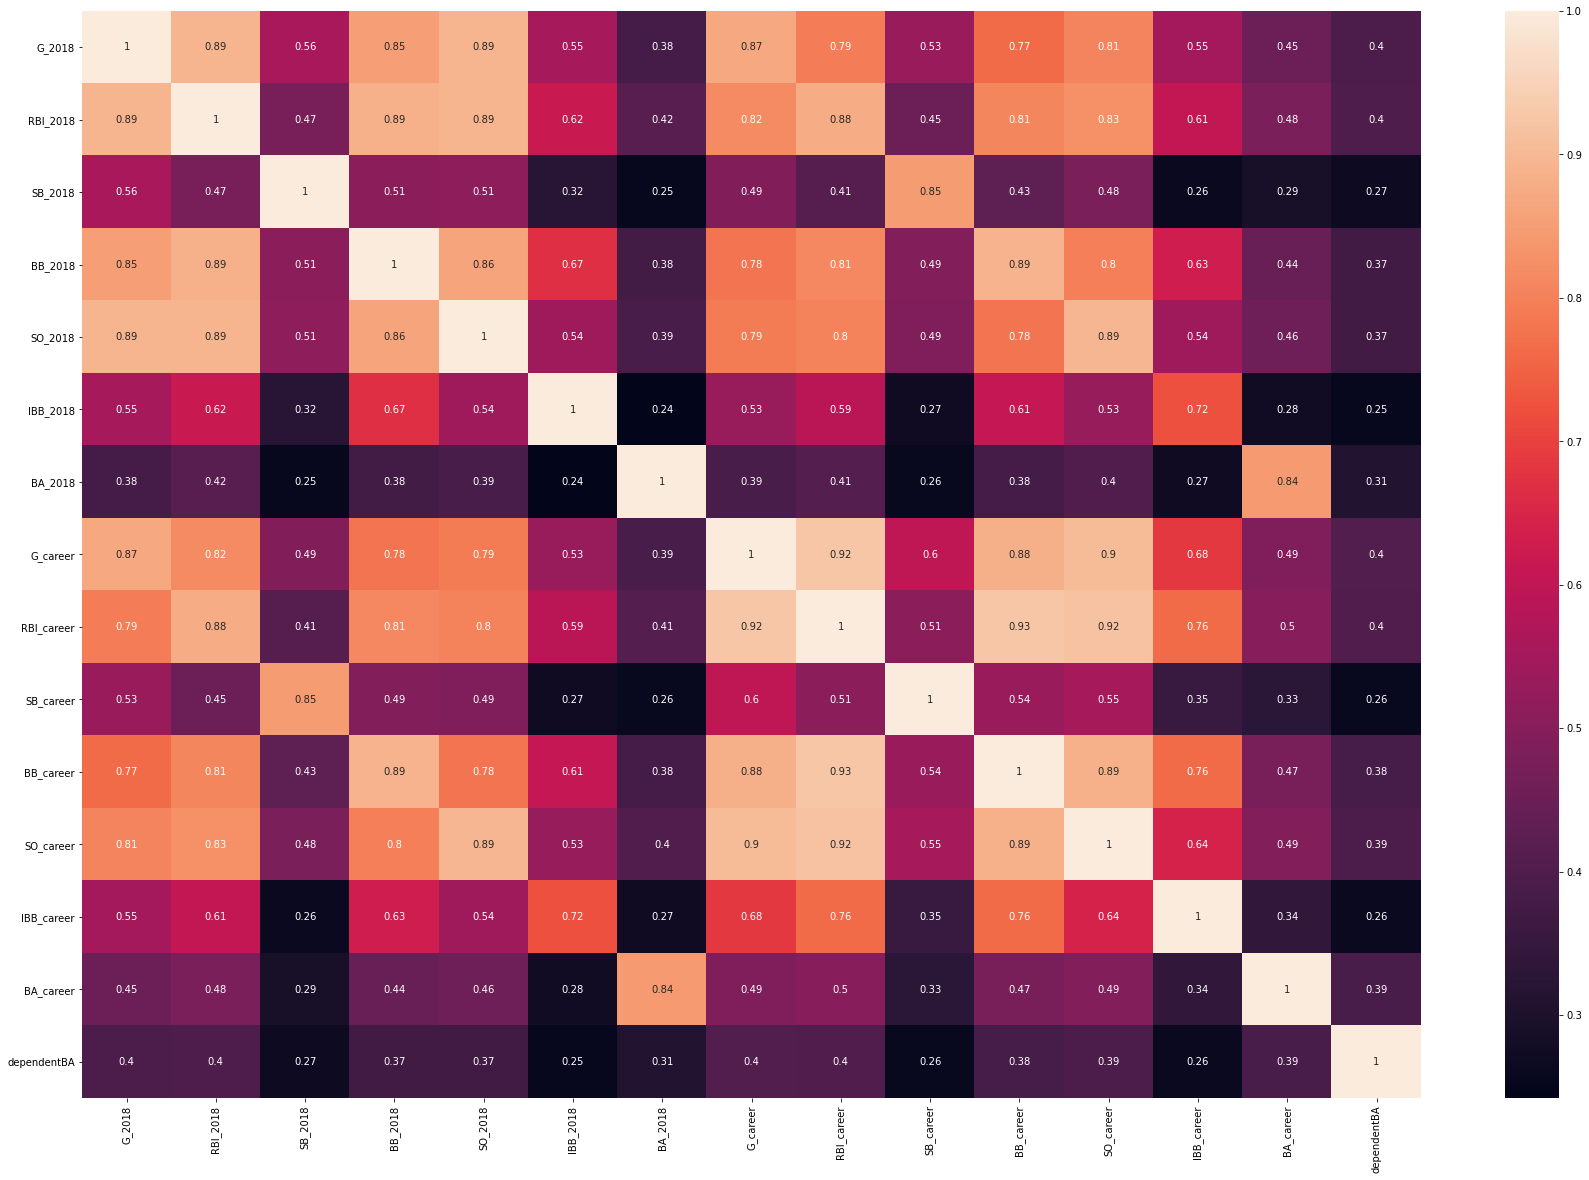

In [91]:
#ax = sns.heatmap(b2018andCareer.corr(), annot = True)
#sns.heatmap(b2018andCareer.corr(), annot = True,xticklabels=True, yticklabels=True)
sns.heatmap(b2018andCareerNew.corr(), annot = True,xticklabels=True, yticklabels=True)
plt.gcf().set_size_inches(30, 20)